### bd CPS graph basic labor market indicators

bd_CPS_grapher.ipynb

September 30, 2018

@bd_econ

Requires: `cpsYYYY.ft`.

____

Notes:

Several [open issues](https://github.com/bdecon/econ_data/issues) on GitHub. This code needs to do four things: 1) read and aggregate CPS data as instructed (one month, three months, one year, two years); 2) Apply some pre-specified calculations, such as the employment-to-population ratio, unemployment rate, usual earnings at various percentiles, etc.; 3) apply adjustments after the fact, such as moving average, or adjustment for inflation; and 4) allow for collecting data on multiple groups during each read cycle. 

Once the collected data are prepared, use matplotlib to generated line plots. 



The [categorization](https://www.frbatlanta.org/chcs/human-capital-currents/2015/0612-measuring-labor-market-status-using-basic-data.aspx) of those not in the labor force is provided by the Federal Reserve Bank of Atlanta. 

In [13]:
# Import packages, adjust settings and set file path
import os
import pandas as pd
import numpy as np

os.chdir('/home/brian/Documents/CPS/data/clean/')

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
plt.rcParams.update({'axes.titlesize': 'x-large'})

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [38]:
# Define functions to collect and graph data
def bd_cps_data(query_str, calc_type, smoothing='12sma'):
    """Calculate various labor market indicators from
       bd CPS annual feather files."""
    # Employment-to-population ratio
    if calc_type == 'epop':
        d = (pd.concat([(pd.read_feather(f'cps_{year}.ft', nthreads=3)
               .query(query_str)
               .filter(items=['PREMPNOT', 'PWSSWGT', 'HRMONTH'])
               .assign(EMP = lambda x: np.where(x['PREMPNOT']==1, 1, 0))
               .groupby('HRMONTH').apply(lambda x: np.average(x['EMP'], weights=x['PWSSWGT']))
               .reset_index()
               .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x['HRMONTH'].astype('str') + '-01'))
               .set_index('DATE')[0]) for year in range(1994, 2019)]))
        
    # Unemployment rate    
    if calc_type == 'unrate':
        d = (pd.concat([(pd.read_feather(f'cps_{year}.ft', nthreads=3)
               .query(query_str)
               .filter(items=['PREMPNOT', 'PWSSWGT', 'HRMONTH'])
               .assign(UNEMP = lambda x: np.where(x['PREMPNOT']==2, x['PWSSWGT'], 0))
               .assign(LF = lambda x: np.where(x['PREMPNOT'].isin([1, 2]), x['PWSSWGT'], 0))
               .groupby('HRMONTH').apply(lambda x: x['UNEMP'].sum() / x['LF'].sum())
               .reset_index()
               .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x['HRMONTH'].astype('str') + '-01'))
               .set_index('DATE')[0]) for year in range(1994, 2019)]))

    # Labor force participation rate
    if calc_type == 'lfpr':
        d = (pd.concat([(pd.read_feather(f'cps_{year}.ft', nthreads=3)
               .query(query_str)
               .filter(items=['PREMPNOT', 'PWSSWGT', 'HRMONTH'])
               .assign(LF = lambda x: np.where(x['PREMPNOT'].isin([1, 2]), 1, 0))
               .groupby('HRMONTH').apply(lambda x: np.average(x['LF'], weights=x['PWSSWGT']))
               .reset_index()
               .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x['HRMONTH'].astype('str') + '-01'))
               .set_index('DATE')[0]) for year in range(1994, 2019)]))
    
    # Union membership rate
    if calc_type == 'union_member':
        d = (pd.concat([(pd.read_feather(f'cps_{year}.ft', nthreads=3)
               .query(query_str)
               .filter(items=['PEERNLAB', 'PWORWGT', 'HRMONTH'])
               .assign(TOTAL = lambda x: np.where(x['PEERNLAB'].isin([1, 2]), x['PWORWGT'], 0))
               .assign(UNION = lambda x: np.where(x['PEERNLAB']==1, x['PWORWGT'], 0))
               .groupby('HRMONTH').apply(lambda x: x['UNION'].sum() / x['TOTAL'].sum())
               .reset_index()
               .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x['HRMONTH'].astype('str') + '-01'))
               .set_index('DATE')[0]) for year in range(1994, 2019)]))

    # Not in the labor force by reason
#    if 'nilf' in calc_type:
#        d = 
    
    # Settings for smoothing of calculated data
    if smoothing == '12sma':
        d = (d.rolling(12)
              .mean()
              .dropna()
              .multiply(100))
    
    if smoothing == None:
        d = (d.multiply(100))
    
    return d
    
        
def labor_mkt_grapher(title, data, color):
    """Graph time series data from 1994 to present, with recession bars
       and the most recent monthly data point labeled and annotated."""
    spcr, spcr2 = (data.max() - data.min()) / 26, (data.max() - data.min()) / 40
    ax = data.plot(figsize=(8, 4), color=color)
    ax = plt.title(title, loc='left')
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color, s=25)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)
    ax = plt.annotate(f'   {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    ax = plt.xlabel('Source: Current Population Survey microdata, 12-month moving average', ha='left', x=0)
    ax = plt.annotate(f'  {data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')

In [15]:
# Example query string used to filter CPS
filters = 'PRTAGE >= 30 and PRTAGE <= 34 and PESEX == 1'
#filters = 'STATE=="NY"'
#filters = 'WBHAO=="Black" and PRTAGE < 25 and PESEX == 1'

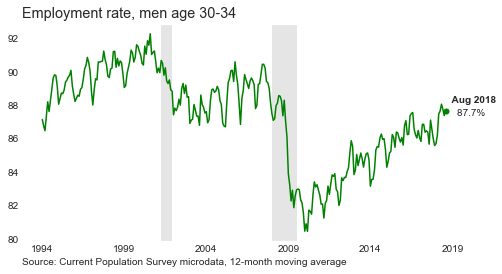

In [39]:
# Employment Rate
calc_type = 'epop'
title = 'Employment rate, men age 30-34'
data = bd_cps_data(filters, calc_type, smoothing=None)
labor_mkt_grapher(title, data, 'green')

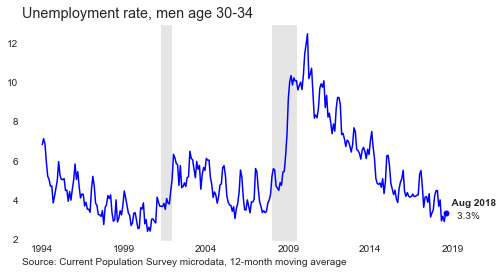

In [40]:
# Unemployment Rate
calc_type = 'unrate'
title = 'Unemployment rate, men age 30-34'
data = bd_cps_data(filters, calc_type, smoothing=None)
labor_mkt_grapher(title, data, 'blue')

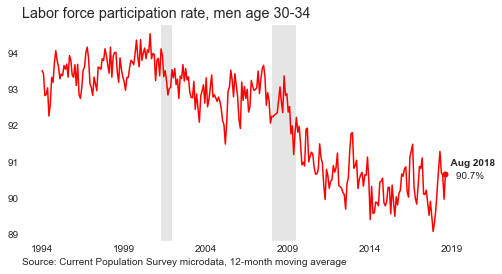

In [41]:
# Labor force participation Rate
calc_type = 'lfpr'
title = 'Labor force participation rate, men age 30-34'
data = bd_cps_data(filters, calc_type, smoothing=None)
labor_mkt_grapher(title, data, 'red')

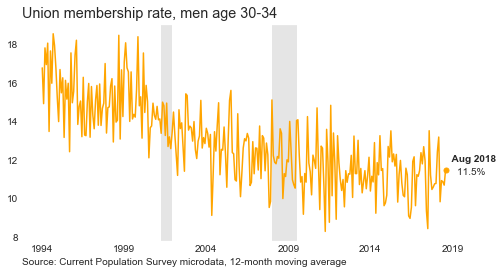

In [42]:
# Union membership rate (uses 1/4 sample)
calc_type = 'union_member'
title = 'Union membership rate, men age 30-34'
data = bd_cps_data(filters, calc_type, smoothing=None)
labor_mkt_grapher(title, data, 'orange')

In [ ]:
  if calc_type == 'disc':
                    dw = np.where(df['PEDWWNTO'].isin([1]), 1, 0)
                    if rtype == 'level':
                        dwrt = ((df['PWSSWGT'] / 100000000) * dw).sum() / 100
                    else:
                        dwrt = (df['PWSSWGT'] * dw).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = dwrt 
                if calc_type == 'nilfsch':
                    ns = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==3), 1, 0)
                    if rtype == 'level':
                        scrt = ((df['PWSSWGT'] / 100000000) * ns).sum() / 100
                    else:
                        scrt = (df['PWSSWGT'] * ns).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = scrt
                if calc_type == 'disill':
                    nd = np.where(((df['PRWNTJOB']==2) & 
                                   ((df['PEMLR']==6) | 
                                    (df['PENLFACT']==1) | 
                                    (df['PENLFACT']==2))), 1, 0)
                    if rtype == 'level':
                        di = ((df['PWSSWGT'] / 100000000) * nd).sum() / 100
                    else:                    
                        di = (df['PWSSWGT'] * nd).sum() / (df['PWSSWGT']).sum() * 100
                    data[pd.to_datetime(f'{year}-{month}-01')] = di
                if calc_type == 'care':
                    care = np.where((df['PRWNTJOB']==2) & (df['PENLFACT']==4), 1, 0)
                    if rtype == 'level':
                        ncare = ((df['PWSSWGT'] / 100000000) * care).sum() / 100
                    else:                      
                        ncare = (df['PWSSWGT'] * care).sum() / (df['PWSSWGT']).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = ncare
                if calc_type == 'union':

In [25]:
calc_type = 'nilf_disability'

In [26]:
if 'nilf' in calc_type:
    print('yes')

yes


In [28]:
query_str = 'PRTAGE >= 30 and PRTAGE <= 34 and PESEX == 1'

In [34]:
reasons = ['DISABILITY', 'DISCOURAGED', 'RETIRED', 'SCHOOL', 'CARE']

In [57]:
(pd.concat([(pd.read_feather(f'cps_{year}.ft', nthreads=3)
               .query(query_str)
               .filter(items=['PEDWWNTO', 'PWSSWGT', 'PENLFACT', 'PRWNTJOB', 'PEMLR', 'HRMONTH'])
               .assign(DISCOURAGED = lambda x: np.where(x['PEDWWNTO'].isin([1]), x['PWSSWGT'], 0))
               .assign(SCHOOL = lambda x: np.where((x['PRWNTJOB']==2) & (x['PENLFACT']==3), x['PWSSWGT'], 0))
               .assign(CARE = lambda x: np.where((x['PRWNTJOB']==2) & (x['PENLFACT']==4), x['PWSSWGT'], 0))
               .assign(DISABILITY = lambda x: np.where(((x['PRWNTJOB']==2) & 
                                                        ((x['PEMLR']==6) | 
                                                         (x['PENLFACT'].isin([1, 2])))), x['PWSSWGT'], 0))
               .assign(RETIRED = lambda x: np.where(((x['PRWNTJOB']==2) & 
                                                     ((x['PEMLR']==5) | 
                                                      (x['PENLFACT']==5))), x['PWSSWGT'], 0))
               .assign(TOTAL = lambda x: np.where(x['PEMLR'].isin([5, 6, 7]), x['PWSSWGT'], 0))
               .assign(OTHER = lambda x: np.where(((x['TOTAL'] > 0) & (x[reason] == 0 for reason in reasons)), x['PWSSWGT'], 0))                                  
               .groupby('HRMONTH').agg(lambda x: x[reasons].sum() / x['TOTAL'].sum())
               .reset_index()
               .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x['HRMONTH'].astype('str') + '-01'))
               .set_index('DATE')) for year in range(1994, 2019)])
               .rolling(12)
               .mean()
               .dropna()
               .multiply(100))

TypeError: cannot compare a dtyped [bool] array with a scalar of type [bool]

In [31]:
['DISABILITY', 'DISCOURAGED', 'RETIRED', 'SCHOOL', 'CARE'] + ['OTHER']

['DISABILITY', 'DISCOURAGED', 'RETIRED', 'SCHOOL', 'CARE', 'OTHER']

In [19]:
pd.read_feather('cps_2018.ft')

/home/brian/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,HRHHID,HRMONTH,HRYEAR4,HRMIS,HRHHID2,GTCBSA,GTMETSTA,PRTAGE,PESEX,PEEDUCA,...,PWSSWGT,PRCHLD,PWCMPWGT,PEIO1ICD,PEIO1OCD,PRDISFLG,STATE,EDUC,WBHAO,HRWAGE
0,71691004941,2,2018,7,6111,26620,1,72,1,40,...,1466.418335,0,1447.698853,7580,9140,2,AL,SC,White,NaN
1,71691004941,2,2018,7,6111,26620,1,73,2,40,...,1619.653076,0,1589.100342,-1,-1,2,AL,SC,White,NaN
2,110116792163,2,2018,2,8011,-31676,1,66,1,43,...,1986.506836,0,1961.148438,7070,4920,2,AL,COLL,White,NaN
3,110116792163,2,2018,2,8011,-31676,1,61,2,43,...,1758.354858,0,1773.754028,8270,350,2,AL,COLL,White,NaN
4,110177987986,2,2018,1,8111,-31676,1,80,2,39,...,1985.531616,0,1948.077148,-1,-1,2,AL,HS,White,NaN
5,110284815680,2,2018,3,8111,-31876,1,73,2,40,...,1686.628784,0,1654.812744,-1,-1,2,AL,SC,White,NaN
6,110327856469,2,2018,7,6111,-31676,1,80,2,33,...,1530.049438,0,1491.522583,-1,-1,1,AL,LTHS,Black,NaN
7,110347170965,2,2018,1,8111,13820,1,85,1,39,...,1422.875854,0,1419.240967,8770,4220,2,AL,HS,Black,NaN
8,110351278134,2,2018,1,8111,-31876,1,85,2,44,...,1541.711548,0,1502.891235,-1,-1,1,AL,ADV,Black,NaN
9,110360812356,2,2018,6,6111,13820,1,23,2,45,...,1697.199585,0,1730.221436,8190,3255,2,AL,ADV,White,NaN


In [ ]:
                if calc_type == 'union':
                    tot = np.where(df['PEERNLAB'].isin([1, 2]), 1, 0)
                    union = np.where(df['PEERNLAB'] == 1, 1, 0)
                    if rtype == 'level':
                        unsh = ((df['PWORWGT'] / 100000000) * union).sum() / 100
                    else:
                        unsh = (df['PWORWGT'] * union).sum() / (df['PWORWGT'] * tot).sum() * 100 
                    data[pd.to_datetime(f'{year}-{month}-01')] = unsh   

In [12]:
query_str = 'PRTAGE >= 30 and PRTAGE <= 34 and PESEX == 1'

In [ ]:
                if calc_type == 'lfpr':
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * lf).sum() / (df['PWSSWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100

In [18]:
(pd.concat([(pd.read_feather(f'cps_{year}.ft', nthreads=3)
               .query(query_str)
               .filter(items=['PEERNLAB', 'PWORWGT', 'HRMONTH'])
               .assign(TOTAL = lambda x: np.where(x['PEERNLAB'].isin([1, 2]), x['PWORWGT'], 0))
               .assign(UNION = lambda x: np.where(x['PEERNLAB']==1, x['PWORWGT'], 0))
               .groupby('HRMONTH').apply(lambda x: x['UNION'].sum() / x['TOTAL'].sum())
               .reset_index()
               .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x['HRMONTH'].astype('str') + '-01'))
               .set_index('DATE')[0]) for year in range(1994, 2019)])
               .rolling(12)
               .mean()
               .dropna()
               .multiply(100))

DATE
1994-12-01    16.688651
1995-01-01    16.455955
1995-02-01    16.603715
1995-03-01    16.409090
1995-04-01    16.351880
1995-05-01    15.943410
1995-06-01    16.164853
1995-07-01    15.955874
1995-08-01    15.955715
1995-09-01    15.444598
1995-10-01    15.412575
1995-11-01    15.262592
1995-12-01    15.289975
1996-01-01    15.578502
1996-02-01    15.705434
1996-03-01    15.568440
1996-04-01    15.443721
1996-05-01    15.601424
1996-06-01    15.357359
1996-07-01    15.452057
1996-08-01    15.227955
1996-09-01    15.297488
1996-10-01    15.085936
1996-11-01    15.169650
1996-12-01    14.971281
1997-01-01    14.834597
1997-02-01    14.510217
1997-03-01    14.491518
1997-04-01    14.520139
1997-05-01    14.587565
                ...    
2016-03-01    11.448803
2016-04-01    11.258623
2016-05-01    11.024373
2016-06-01    10.745043
2016-07-01    10.566009
2016-08-01    10.535354
2016-09-01    10.731642
2016-10-01    10.596962
2016-11-01    10.535276
2016-12-01    10.564436
2017-01-01 